<a href="https://colab.research.google.com/github/BillWorstell/ISBI2020_TUTORIAL/blob/master/08_segmentation_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">Segmentation Evaluation</h1>

**Summary:**

1. SimpleITK supports two ways of combining expert segmentations to obtain a reference segmentation.
2. A variety of criteria used for evaluating a segmentation result are readily available or implemented in SimpleITK.

<u>Reference Segmentation</u>

Evaluating segmentation algorithms is most often done using reference data to which you compare your results. In the medical domain reference data is commonly obtained via manual segmentation by an expert (don't forget to thank your clinical colleagues for their hard work). When you are resource limited, the reference data may be defined by a single expert. This is less than ideal. When multiple experts provide you with their input then you can potentially combine them to obtain reference data that is closer to the ever elusive "ground truth". In this notebook we show two approaches to combining input from multiple observers, majority vote and the Simultaneous Truth and Performance Level
Estimation [(STAPLE)](https://www.ncbi.nlm.nih.gov/pubmed/15250643) algorithm.

<u>Segmentation Evaluation</u>

Once we have a reference, we compare the algorithm's performance using multiple criteria, as usually there is no single evaluation measure that conveys all of the relevant information. In this notebook we illustrate the use of the following evaluation criteria:
* Overlap measures:
  * Jaccard and Dice coefficients 
  * false negative and false positive errors
* Surface distance measures:
  * Hausdorff distance (symmetric)
  * mean, median, max and standard deviation between surfaces
* Volume measures:
  * volume similarity $ \frac{2*(v1-v2)}{v1+v2}$

The relevant criteria are task dependent, so you need to ask yourself whether you are interested in detecting spurious errors or not (mean or max surface distance), whether over/under segmentation should be differentiated (volume similarity and Dice or just Dice), and what is the ratio between acceptable errors and the size of the segmented object (Dice coefficient may be too sensitive to small errors when the segmented object is small and not sensitive enough to large errors when the segmented object is large).

In the context of segmentation challenges, algorithm rankings are often based on a weighted combination of these criteria. These ranking schemes are not necessarily robust, as discussed in "[Why rankings of biomedical image analysis competitions should be interpreted with care](https://www.nature.com/articles/s41467-018-07619-7)", L. Maier-Hein et al.

The data we use in the notebook is a set of manually segmented liver tumors from a single clinical CT scan. A larger dataset (four scans) is freely available from this [MIDAS repository](http://www.insight-journal.org/midas/collection/view/38). The relevant publication is: T. Popa et al., "Tumor Volume Measurement and Volume Measurement Comparison Plug-ins for VolView Using ITK", SPIE Medical Imaging: Visualization, Image-Guided Procedures, and Display, 2006.


## Install SimpleITK and Environment

Expects to find on MyDrive:
 
/gdrive/MyDrive/SimpleITK-Notebooks/Python

/gdrive/MyDrive/SimpleITK-Notebooks/Python/requirements.txt

/gdrive/MyDrive/Fiji.app/ImageJ-linux64

<img src="figures/ImageOriginAndSpacing.png" style="width:700px"/><br><br>

In [1]:
pip install virtualenv

     |████████████████████████████████| 7.2MB 5.5MB/s 
     |████████████████████████████████| 337kB 44.3MB/s 


In [2]:
#!virtualenv ~/sitkpy --no-site-packages
!virtualenv ~/sitkpy

created virtual environment CPython3.7.10.final.0-64 in 921ms
  creator CPython3Posix(dest=/root/sitkpy, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==21.0.1, setuptools==52.0.0, wheel==0.36.2
  activators BashActivator,CShellActivator,FishActivator,PowerShellActivator,PythonActivator,XonshActivator


In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [4]:
#!pip install -r '/gdrive/MyDrive/SimpleITK-Notebooks/Python/requirements.txt'
!~/sitkpy/bin/pip install -r '/gdrive/MyDrive/SimpleITK-Notebooks/Python/requirements.txt'

     |████████████████████████████████| 47.4 MB 52 kB/s 
     |████████████████████████████████| 11.5 MB 43.4 MB/s 
     |████████████████████████████████| 121 kB 71.3 MB/s 
     |████████████████████████████████| 15.3 MB 156 kB/s 
     |████████████████████████████████| 27.4 MB 74 kB/s 
     |████████████████████████████████| 9.9 MB 46.5 MB/s 
     |████████████████████████████████| 3.2 MB 37.7 MB/s 
     |████████████████████████████████| 108 kB 71.8 MB/s 
     |████████████████████████████████| 784 kB 46.5 MB/s 
     |████████████████████████████████| 120 kB 70.2 MB/s 
     |████████████████████████████████| 113 kB 67.5 MB/s 
     |████████████████████████████████| 100 kB 8.4 MB/s 
     |████████████████████████████████| 2.2 MB 58.8 MB/s 
     |████████████████████████████████| 243 kB 73.7 MB/s 
     |████████████████████████████████| 108 kB 73.2 MB/s 
     |████████████████████████████████| 428 kB 69.3 MB/s 
     |████████████████████████████████| 59 kB 5.0 MB/s 
     |████████████

In [5]:
cd '/gdrive/MyDrive/SimpleITK-Notebooks/Python'

/gdrive/MyDrive/SimpleITK-Notebooks/Python


In [6]:
pip install SimpleITK

  Using cached https://files.pythonhosted.org/packages/9c/6b/85df5eb3a8059b23a53a9f224476e75473f9bcc0a8583ed1a9c34619f372/SimpleITK-2.0.2-cp37-cp37m-manylinux2010_x86_64.whl


In [7]:
pip install ipywidgets

In [8]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [9]:
%ls -ltr '/gdrive/MyDrive/Fiji.app/ImageJ-linux64'

-rw------- 1 root root 90243 Feb 27 18:15 /gdrive/MyDrive/Fiji.app/ImageJ-linux64


In [10]:
!pip install itk

#!~/sitkpy/bin/pip install ITK

     |████████████████████████████████| 10.3MB 2.6MB/s 
     |████████████████████████████████| 36.3MB 89kB/s 
     |████████████████████████████████| 14.4MB 340kB/s 
     |████████████████████████████████| 50.1MB 79kB/s 
     |████████████████████████████████| 68.0MB 60kB/s 
     |████████████████████████████████| 14.0MB 340kB/s 


In [11]:
!echo $PATH

/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin


In [12]:
import os
#os.environ['PYTHONPATH'] += ":/content/gdrive/My Drive/Colab Notebooks/MNIST_Classifier/src"
os.environ['PATH'] += ":/content/gdrive/My Drive/Fiji.app"
! echo $PATH

/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin:/content/gdrive/My Drive/Fiji.app


In [13]:
cd '/gdrive/MyDrive/SimpleITK-Notebooks/Python'

/gdrive/MyDrive/SimpleITK-Notebooks/Python


In [14]:
import SimpleITK as sitk

%run update_path_to_download_script
from downloaddata import fetch_data, fetch_data_all

from ipywidgets import interact

print(sitk.Version())

SimpleITK Version: 2.0.2 (ITK 5.1)
Compiled: Dec  1 2020 22:01:03



In [15]:
cd /usr/local/

/usr/local


In [16]:
import shutil

In [17]:
%ls /gdrive/MyDrive/

'Colab Notebooks'/                      SimpleITK_ISBI2020_TUTORIAL/
 Fiji.app/                              SimpleITK.jpg
 fiji-linux64-20170530.zip              SimpleITK-Notebooks/
 MyNiftyRec/                            unnamed.png
 MyTomoLab/                            'Untitled project.gscript'
 pyjnius-1.2.0-py37h90b5fae_0.tar.bz2


In [18]:
shutil.copyfile('/gdrive/MyDrive/fiji-linux64-20170530.zip', '/usr/local/fiji-linux64-20170530.zip')

'/usr/local/fiji-linux64-20170530.zip'

In [19]:
cd /usr/local

/usr/local


In [20]:
!unzip ./fiji-linux64-20170530.zip

Archive:  ./fiji-linux64-20170530.zip
  inflating: Fiji.app/db.xml.gz      
  inflating: Fiji.app/Contents/Info.plist  
  inflating: Fiji.app/Contents/Resources/Fiji.icns  
  inflating: Fiji.app/Contents/Resources/ImageJ.icns  
  inflating: Fiji.app/ImageJ-linux64  
  inflating: Fiji.app/plugins/3D_Blob_Segmentation-3.0.0.jar  
  inflating: Fiji.app/plugins/3D_Objects_Counter-2.0.0.jar  
  inflating: Fiji.app/plugins/3D_Viewer-4.0.1.jar  
  inflating: Fiji.app/plugins/Algorithm_Launcher.jar  
  inflating: Fiji.app/plugins/Analyze/Dynamic_ROI_Profiler.clj  
  inflating: Fiji.app/plugins/Analyze/Measure_RGB.txt  
  inflating: Fiji.app/plugins/AnalyzeSkeleton_-3.1.2.jar  
  inflating: Fiji.app/plugins/Anisotropic_Diffusion_2D-2.0.0.jar  
  inflating: Fiji.app/plugins/Archipelago_Plugins-0.5.2.jar  
  inflating: Fiji.app/plugins/Arrow_-2.0.1.jar  
  inflating: Fiji.app/plugins/Auto_Threshold-1.16.4.jar  
  inflating: Fiji.app/plugins/BalloonSegmentation_-3.0.0.jar  
  inflating: Fiji.app/p

In [21]:
#!pip install SimpleITK

In [22]:
#!git clone https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks.git

In [23]:
pip install ipywidgets

In [24]:
# this will allow the notebook to reload/refresh automatically within the runtime
%reload_ext autoreload
%autoreload 2

from ipywidgets import interact

def f(x):
  return x

interact(f, x=10)

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

<function __main__.f>

In [25]:
#pip install itk

In [26]:
cd '/gdrive/MyDrive/SimpleITK-Notebooks/Python/'

/gdrive/MyDrive/SimpleITK-Notebooks/Python


In [27]:
!python '/gdrive/MyDrive/SimpleITK-Notebooks/Python/update_path_to_download_script.py'

In [28]:
import os
os.environ['PYTHONPATH'] += ":/content/gdrive/My Drive/Fiji.app"
! echo $PYTHONPATH
os.environ['PATH'] += ":/content/gdrive/My Drive/Fiji.app"
! echo $PATH

/env/python:/content/gdrive/My Drive/Fiji.app
/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin:/content/gdrive/My Drive/Fiji.app:/content/gdrive/My Drive/Fiji.app


In [29]:
import numpy as np
import os
from ipywidgets import interact, fixed

%matplotlib inline
import matplotlib.pyplot as plt

from downloaddata import fetch_data as fdata

OUTPUT_DIR = 'output'

image_viewer = sitk.ImageViewer()

In [30]:
print(image_viewer)

itk::simple::ImageViewer
  Title: 
  Command: %a -eval 'open("%f"); rename("%t");'
  Application: /usr/local/Fiji.app/ImageJ-linux64
  Default Application: /usr/local/Fiji.app/ImageJ-linux64
  File Extension: .mha
  Default File Extension: .mha
  Search Path: [ ./, /root/bin/, /opt/, /usr/local/ ]
  Executable Names: [ Fiji.app/ImageJ-linux64, Fiji.app/ImageJ-linux32 ]
  Debug Flag: 0



In [31]:
%ls /usr/local/Fiji.app/ImageJ-linux64

/usr/local/Fiji.app/ImageJ-linux64*


In [32]:
#!python '/gdrive/MyDrive/SimpleITK-Notebooks/Python/update_path_to_download_script.py'

In [33]:
cd '/gdrive/MyDrive/SimpleITK-Notebooks/Python/'

/gdrive/MyDrive/SimpleITK-Notebooks/Python


In [34]:
import SimpleITK as sitk

%run update_path_to_download_script
from downloaddata import fetch_data, fetch_data_all

from ipywidgets import interact

print(sitk.Version())

SimpleITK Version: 2.0.2 (ITK 5.1)
Compiled: Dec  1 2020 22:01:03



In [35]:
%cd '/gdrive/MyDrive/'
%ls

/gdrive/MyDrive
'Colab Notebooks'/                      SimpleITK_ISBI2020_TUTORIAL/
 Fiji.app/                              SimpleITK.jpg
 fiji-linux64-20170530.zip              SimpleITK-Notebooks/
 MyNiftyRec/                            unnamed.png
 MyTomoLab/                            'Untitled project.gscript'
 pyjnius-1.2.0-py37h90b5fae_0.tar.bz2


In [36]:
cd /usr/local/

/usr/local


In [37]:
#image_viewer.SetApplication('/usr/local/Fiji.app/ImageJ-linux64')

In [38]:
# Uncomment the line below to change the default external viewer to your viewer of choice and test that it works.
#%env SITK_SHOW_COMMAND /Applications/ITK-SNAP.app/Contents/MacOS/ITK-SNAP 
#%env SITK_SHOW_COMMAND  /gdrive/MyDrive/Fiji.app/ImageJ-linux64
#%env SITK_SHOW_COMMAND  /usr/local/Fiji.app/
#%env SITK_SHOW_COMMAND  /usr/local/Fiji.app/ImageJ-linux64

# Retrieve an image from the network, read it and display using the external viewer. 
# The show method will also set the display window's title and by setting debugOn to True, 
# will also print information with respect to the command it is attempting to invoke.
# NOTE: The debug information is printed to the terminal from which you launched the notebook
#       server.

In [39]:
%ls /gdrive/MyDrive/

'Colab Notebooks'/                      SimpleITK_ISBI2020_TUTORIAL/
 Fiji.app/                              SimpleITK.jpg
 fiji-linux64-20170530.zip              SimpleITK-Notebooks/
 MyNiftyRec/                            unnamed.png
 MyTomoLab/                            'Untitled project.gscript'
 pyjnius-1.2.0-py37h90b5fae_0.tar.bz2


In [40]:
%cd /gdrive/MyDrive/SimpleITK_ISBI2020_TUTORIAL

/gdrive/MyDrive/SimpleITK_ISBI2020_TUTORIAL


In [41]:
print(image_viewer)

itk::simple::ImageViewer
  Title: 
  Command: %a -eval 'open("%f"); rename("%t");'
  Application: /usr/local/Fiji.app/ImageJ-linux64
  Default Application: /usr/local/Fiji.app/ImageJ-linux64
  File Extension: .mha
  Default File Extension: .mha
  Search Path: [ ./, /root/bin/, /opt/, /usr/local/ ]
  Executable Names: [ Fiji.app/ImageJ-linux64, Fiji.app/ImageJ-linux32 ]
  Debug Flag: 0



In [42]:
#import SimpleITK as sitk

#%matplotlib inline
#import matplotlib.pyplot as plt
#import numpy as np

#from ipywidgets import interact, fixed
#import os

#OUTPUT_DIR = 'Output'

# Utility method that either downloads data from the Girder repository or
# if already downloaded returns the file name for reading from disk (cached data).
#%run update_path_to_download_script
#from downloaddata import fetch_data as fdata

In [43]:
import SimpleITK as sitk

import numpy as np

from downloaddata import fetch_data as fdata
%matplotlib inline
import matplotlib.pyplot as plt
import gui

from ipywidgets import interact, fixed

## Utility method for display

In [44]:
def display_with_overlay(segmentation_number, slice_number, image, segs, window_min, window_max):
    """
    Display a CT slice with segmented contours overlaid onto it. The contours are the edges of 
    the labeled regions.
    """
    img = image[:,:,slice_number]
    msk = segs[segmentation_number][:,:,slice_number]
    overlay_img = sitk.LabelMapContourOverlay(sitk.Cast(msk, sitk.sitkLabelUInt8), 
                                              sitk.Cast(sitk.IntensityWindowing(img,
                                                                                windowMinimum=window_min, 
                                                                                windowMaximum=window_max), 
                                                        sitk.sitkUInt8), 
                                             opacity = 1, 
                                             contourThickness=[2,2])
    #We assume the original slice is isotropic, otherwise the display would be distorted 
    plt.imshow(sitk.GetArrayViewFromImage(overlay_img))
    plt.axis('off')
    plt.show()

## Fetch the data

Retrieve a single CT scan and three manual delineations of a liver tumor. Visual inspection of the data highlights the variability between experts. 

In [45]:
image = sitk.ReadImage(fdata("liverTumorSegmentations/Patient01Homo.mha"))
segmentation_file_names = ["liverTumorSegmentations/Patient01Homo_Rad01.mha", 
                          "liverTumorSegmentations/Patient01Homo_Rad02.mha",
                          "liverTumorSegmentations/Patient01Homo_Rad03.mha"]
                          
segmentations = [sitk.ReadImage(fdata(file_name), sitk.sitkUInt8) for file_name in segmentation_file_names]
    
interact(display_with_overlay, segmentation_number=(0,len(segmentations)-1), 
         slice_number = (0, image.GetSize()[2]-1), image = fixed(image),
         segs = fixed(segmentations), window_min = fixed(-1024), window_max=fixed(976));

Fetching liverTumorSegmentations/Patient01Homo.mha
Downloaded 1365461 of 1365461 bytes (100.00%)
Fetching liverTumorSegmentations/Patient01Homo_Rad01.mha
Downloaded 3757 of 3757 bytes (100.00%)
Fetching liverTumorSegmentations/Patient01Homo_Rad02.mha
Downloaded 3722 of 3722 bytes (100.00%)
Fetching liverTumorSegmentations/Patient01Homo_Rad03.mha
Downloaded 3796 of 3796 bytes (100.00%)


interactive(children=(IntSlider(value=1, description='segmentation_number', max=2), IntSlider(value=48, descri…

## Derive a reference

There are a variety of ways to derive a reference segmentation from multiple expert inputs ("[A comparison of ground truth estimation methods](https://www.ncbi.nlm.nih.gov/pubmed/20033494)", A. M. Biancardi, A. C. Jirapatnakul, A. P. Reeves).

Two methods that are available in SimpleITK are [majority vote](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1LabelVotingImageFilter.html) and the STAPLE algorithm ([single label](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1STAPLEImageFilter.html) or [multi label](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1MultiLabelSTAPLEImageFilter.html)).

In [46]:
# Use the STAPLE algorithm to obtain the reference segmentation. This implementation of the original algorithm
# combines a single label from multiple segmentations, the label is user specified. The result of the
# filter is the voxel's probability of belonging to the foreground. We then have to threshold the result to obtain
# a reference binary segmentation.
foregroundValue = 1
threshold = 0.95
reference_segmentation_STAPLE_probabilities = sitk.STAPLE(segmentations, foregroundValue) 
# We use the overloaded operator to perform thresholding, another option is to use the BinaryThreshold function.
reference_segmentation = reference_segmentation_STAPLE_probabilities > threshold

manual_plus_staple = list(segmentations)  
# Append the reference segmentation to the list of manual segmentations
manual_plus_staple.append(reference_segmentation)

interact(display_with_overlay, segmentation_number=(0,len(manual_plus_staple)-1), 
         slice_number = (0, image.GetSize()[1]-1), image = fixed(image),
         segs = fixed(manual_plus_staple), window_min = fixed(-1024), window_max=fixed(976));

interactive(children=(IntSlider(value=1, description='segmentation_number', max=3), IntSlider(value=88, descri…

## Evaluate segmentations using the reference

Once we derive a reference from our experts input we can compare segmentation results to it.

Note that in this notebook we compare the expert segmentations to the reference derived from them. This is not relevant for algorithm evaluation, but it can potentially be used to rank your experts.

In this specific implementation we take advantage of the fact that we have a binary segmentation with 1 for foreground and 0 for background.

In [47]:
from enum import Enum

# Use enumerations to represent the various evaluation measures
class OverlapMeasures(Enum):
    jaccard, dice, volume_similarity, false_negative, false_positive = range(5)

class SurfaceDistanceMeasures(Enum):
    hausdorff_distance, mean_surface_distance, median_surface_distance, std_surface_distance, max_surface_distance = range(5)
    
# Empty numpy arrays to hold the results 
overlap_results = np.zeros((len(segmentations),len(OverlapMeasures.__members__.items())))  
surface_distance_results = np.zeros((len(segmentations),len(SurfaceDistanceMeasures.__members__.items())))  

# Compute the evaluation criteria

# Note that for the overlap measures filter, because we are dealing with a single label we 
# use the combined, all labels, evaluation measures without passing a specific label to the methods.
overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()

hausdorff_distance_filter = sitk.HausdorffDistanceImageFilter()

# Use the absolute values of the distance map to compute the surface distances (distance map sign, outside or inside 
# relationship, is irrelevant)
label = 1
reference_distance_map = sitk.Abs(sitk.SignedMaurerDistanceMap(reference_segmentation, squaredDistance=False, useImageSpacing=True))
reference_surface = sitk.LabelContour(reference_segmentation)

statistics_image_filter = sitk.StatisticsImageFilter()
# Get the number of pixels in the reference surface by counting all pixels that are 1.
statistics_image_filter.Execute(reference_surface)
num_reference_surface_pixels = int(statistics_image_filter.GetSum()) 

for i, seg in enumerate(segmentations):
    # Overlap measures
    overlap_measures_filter.Execute(reference_segmentation, seg)
    overlap_results[i,OverlapMeasures.jaccard.value] = overlap_measures_filter.GetJaccardCoefficient()
    overlap_results[i,OverlapMeasures.dice.value] = overlap_measures_filter.GetDiceCoefficient()
    overlap_results[i,OverlapMeasures.volume_similarity.value] = overlap_measures_filter.GetVolumeSimilarity()
    overlap_results[i,OverlapMeasures.false_negative.value] = overlap_measures_filter.GetFalseNegativeError()
    overlap_results[i,OverlapMeasures.false_positive.value] = overlap_measures_filter.GetFalsePositiveError()
    # Hausdorff distance
    hausdorff_distance_filter.Execute(reference_segmentation, seg)
    
    surface_distance_results[i,SurfaceDistanceMeasures.hausdorff_distance.value] = hausdorff_distance_filter.GetHausdorffDistance()
    # Symmetric surface distance measures
    segmented_distance_map = sitk.Abs(sitk.SignedMaurerDistanceMap(seg, squaredDistance=False, useImageSpacing=True))
    segmented_surface = sitk.LabelContour(seg)
        
    # Multiply the binary surface segmentations with the distance maps. The resulting distance
    # maps contain non-zero values only on the surface (they can also contain zero on the surface)
    seg2ref_distance_map = reference_distance_map*sitk.Cast(segmented_surface, sitk.sitkFloat32)
    ref2seg_distance_map = segmented_distance_map*sitk.Cast(reference_surface, sitk.sitkFloat32)
        
    # Get the number of pixels in the reference surface by counting all pixels that are 1.
    statistics_image_filter.Execute(segmented_surface)
    num_segmented_surface_pixels = int(statistics_image_filter.GetSum())
    
    # Get all non-zero distances and then add zero distances if required.
    seg2ref_distance_map_arr = sitk.GetArrayViewFromImage(seg2ref_distance_map)
    seg2ref_distances = list(seg2ref_distance_map_arr[seg2ref_distance_map_arr!=0]) 
    seg2ref_distances = seg2ref_distances + \
                        list(np.zeros(num_segmented_surface_pixels - len(seg2ref_distances)))
    ref2seg_distance_map_arr = sitk.GetArrayViewFromImage(ref2seg_distance_map)
    ref2seg_distances = list(ref2seg_distance_map_arr[ref2seg_distance_map_arr!=0]) 
    ref2seg_distances = ref2seg_distances + \
                        list(np.zeros(num_reference_surface_pixels - len(ref2seg_distances)))
        
    all_surface_distances = seg2ref_distances + ref2seg_distances

    # The maximum of the symmetric surface distances is the Hausdorff distance between the surfaces. In 
    # general, it is not equal to the Hausdorff distance between all voxel/pixel points of the two 
    # segmentations, though in our case it is. More on this below.
    surface_distance_results[i,SurfaceDistanceMeasures.mean_surface_distance.value] = np.mean(all_surface_distances)
    surface_distance_results[i,SurfaceDistanceMeasures.median_surface_distance.value] = np.median(all_surface_distances)
    surface_distance_results[i,SurfaceDistanceMeasures.std_surface_distance.value] = np.std(all_surface_distances)
    surface_distance_results[i,SurfaceDistanceMeasures.max_surface_distance.value] = np.max(all_surface_distances)
    
# Print the matrices
np.set_printoptions(precision=3)
print(overlap_results)
print(surface_distance_results)

[[ 0.82   0.901  0.052  0.075  0.122]
 [ 0.881  0.937 -0.013  0.069  0.057]
 [ 0.843  0.915 -0.088  0.124  0.044]]
[[4.905 0.459 0.    0.85  4.905]
 [3.469 0.29  0.    0.689 3.469]
 [5.203 0.431 0.    0.831 5.203]]


## Improved output

Using the [pandas](http://pandas.pydata.org/) package we can easily produce high quality output. 

,jaccard,dice,volume_similarity,false_negative,false_positive
0,0.820,0.901,0.052,0.075,0.122
1,0.881,0.937,-0.013,0.069,0.057
2,0.843,0.915,-0.088,0.124,0.044


,hausdorff_distance,mean_surface_distance,median_surface_distance,std_surface_distance,max_surface_distance
0,4.905,0.459,0.000,0.850,4.905
1,3.469,0.290,0.000,0.689,3.469
2,5.203,0.431,0.000,0.831,5.203


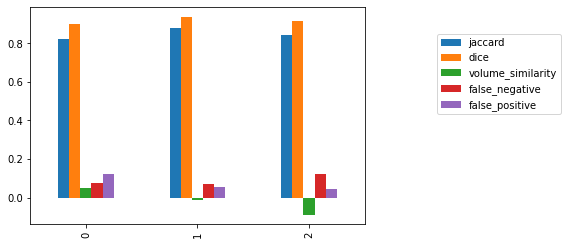

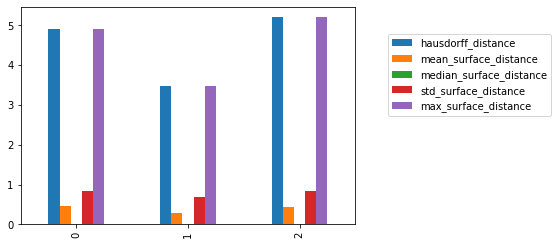

In [48]:
import pandas as pd
from IPython.display import display, HTML 

# Graft our results matrix into pandas data frames 
overlap_results_df = pd.DataFrame(data=overlap_results, index = list(range(len(segmentations))), 
                                  columns=[name for name, _ in OverlapMeasures.__members__.items()]) 
surface_distance_results_df = pd.DataFrame(data=surface_distance_results, index = list(range(len(segmentations))), 
                                  columns=[name for name, _ in SurfaceDistanceMeasures.__members__.items()]) 

# Display the data as HTML tables and graphs
display(HTML(overlap_results_df.to_html(float_format=lambda x: '%.3f' % x)))
display(HTML(surface_distance_results_df.to_html(float_format=lambda x: '%.3f' % x)))
overlap_results_df.plot(kind='bar').legend(bbox_to_anchor=(1.6,0.9))
surface_distance_results_df.plot(kind='bar').legend(bbox_to_anchor=(1.6,0.9))

You can also export the data as a table for your LaTeX manuscript using the [to_latex](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_latex.html) function.
<b>Note</b>: You will need to add the \usepackage{booktabs} to your LaTeX document's preamble. 

To create the minimal LaTeX document which will allow you to see the difference between the tables below, copy paste:

\documentclass{article}

\usepackage{booktabs}

\begin{document}

paste the tables here

\end{document}



In [49]:
# The formatting of the table using the default settings is less than ideal 
print(overlap_results_df.to_latex())

# We can improve on this by specifying the table's column format and the float format
print(overlap_results_df.to_latex(column_format='ccccccc', float_format=lambda x: '%.3f' % x))

\begin{tabular}{lrrrrr}
\toprule
{} &   jaccard &      dice &  volume\_similarity &  false\_negative &  false\_positive \\
\midrule
0 &  0.820124 &  0.901174 &           0.052253 &        0.074650 &        0.121771 \\
1 &  0.881379 &  0.936950 &          -0.013196 &        0.069192 &        0.056827 \\
2 &  0.842653 &  0.914608 &          -0.087509 &        0.123732 &        0.043542 \\
\bottomrule
\end{tabular}

\begin{tabular}{ccccccc}
\toprule
{} &  jaccard &  dice &  volume\_similarity &  false\_negative &  false\_positive \\
\midrule
0 &    0.820 & 0.901 &              0.052 &           0.075 &           0.122 \\
1 &    0.881 & 0.937 &             -0.013 &           0.069 &           0.057 \\
2 &    0.843 & 0.915 &             -0.088 &           0.124 &           0.044 \\
\bottomrule
\end{tabular}



## Visual Diff

It is always nice to have a figure with a visual display of the difference between the segmentation and ground truth.

In [50]:
# Use the first segmentation 
segmentation = segmentations[0]

# Save ink, the differences will be in black and background is white 
segmentation_diff = (segmentation==reference_segmentation)*255

# Flatten for 2D presentation, create a montage from the volume
num_slices = segmentation_diff.GetDepth()
tile_w = int(np.sqrt(num_slices))
tile_h = int(np.ceil(num_slices/tile_w))
default_background_color = 255
tile_image = sitk.Tile([segmentation_diff[:,:,i] for i in range(num_slices)], (tile_w, tile_h), default_background_color)
sitk.Show(tile_image)

<a href="09_results_visualization.ipynb"><h2 align=right>Next &raquo;</h2></a>